Trying to put some code together to identify the snow-atmosphere interface from the SIMBA instead of manually doing it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
import datetime
import cmocean
from matplotlib.dates import DateFormatter
import glob
from astropy.convolution import convolve


In [2]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [3]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.

    From: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [4]:
simba_filepath = '/psd3data/arctic/raven/simba/level1/'
lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## on our server the simba files include some days from march during testing; this gets rid of those files
lev1_files = lev1_files[5:]

In [5]:
## these are the only variables I've used so far from the SIMBA
varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
        
    ## shape of temperature is (time, height)
    # print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

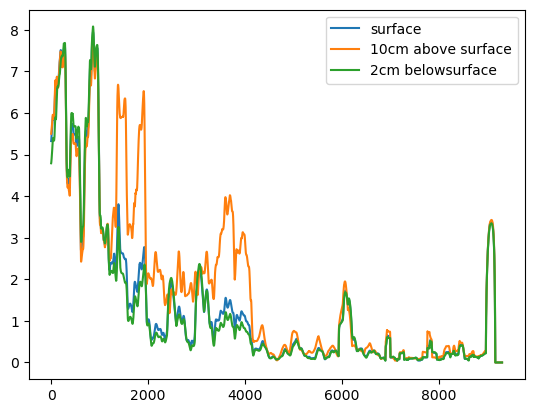

In [6]:
heights = season_data['height']

h=48*4 ## time period that standard deviation is calculated over
kernel_avg_3 = [1./(3)]*(3) # for smoothing temp vertically

known_height = []
above_height = []
below_height = []

std_profiles = []
vert_profiles = []
vert_profiles_sm = [] ## calculated using smoothed temperature profiles

## I'm thinking I want to look at how the above variables decrease to get sfc id
std_gradient_profiles = []
second_vert_profiles = []
second_vert_profiles_sm = [] ## calculated using smoothed temperature profiles



vertical_subset = np.where((heights<-120)&(heights>-400))[0] ## since we're only looking for the surface cut off lower depths

plt_dates = []

for idx, t in np.ndenumerate(season_data['dates'][:]):
    if t<datetime.datetime(2024,5,15):
        continue
    
    # probably a good idea to base off of datetimes and time deltas to deal with missing data
    t_temp = season_data['temperature'][idx[0]:int(idx[0]+h),:].std(axis=0)
    std_profiles.append(t_temp)


    t_temp_vert = np.gradient(season_data['temperature'][idx[0],vertical_subset])
    vert_profiles.append(t_temp_vert)

    T_smoothed = convolve(season_data['temperature'][idx[0],vertical_subset], kernel_avg_3, boundary='extend')
    t_temp_vert_sm = np.gradient(T_smoothed)
    vert_profiles_sm.append(t_temp_vert_sm)
    second_vert_profiles_sm.append(np.gradient(t_temp_vert_sm))

    
    t_temp_vert_grad = np.gradient(t_temp_vert)
    second_vert_profiles.append(t_temp_vert_grad)

    t_temp_grad = np.gradient(t_temp)
    std_gradient_profiles.append(t_temp_grad)
    
    plt_dates.append(t)
    known_height.append(t_temp[np.where(heights==-175*2)[0]])
    above_height.append(t_temp[np.where(heights==-175*2+10)[0]])
    below_height.append(t_temp[np.where(heights==-175*2-2)[0]])




plt.plot(known_height, label='surface')
plt.plot(above_height, label='10cm above surface')
plt.plot(below_height, label='2cm belowsurface')
plt.legend(loc='best')
plt.show()

Plot the data saved above, which was most of what I was using to estimate the surface

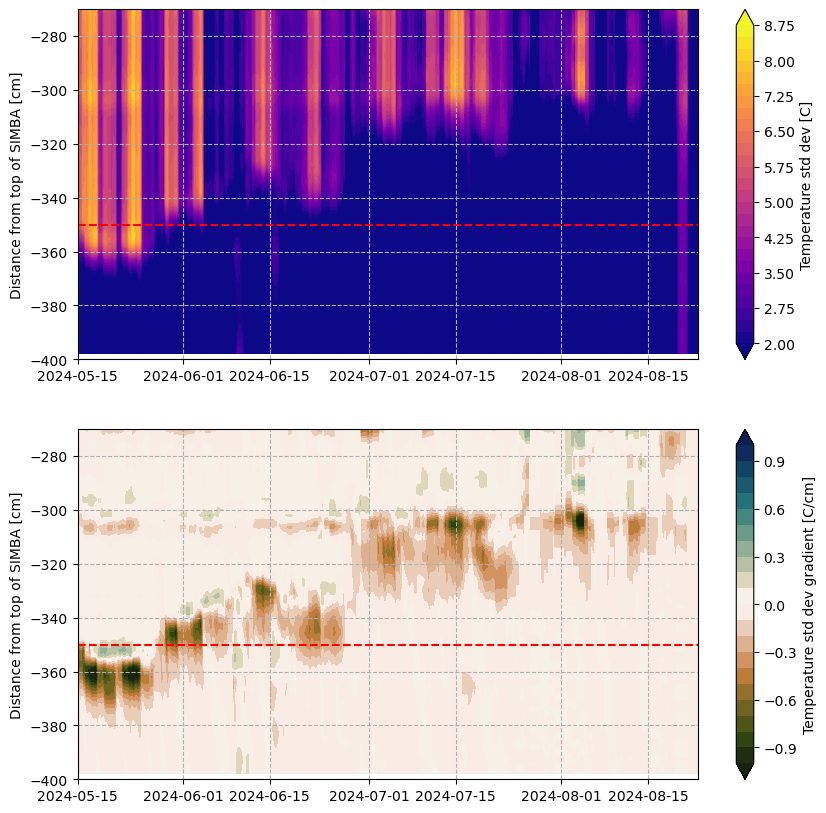

In [7]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)
cb = axs[0].contourf(plt_dates, heights[vertical_subset], np.swapaxes(np.asarray(std_profiles)[:,vertical_subset],0,1),
                cmap=plt.cm.plasma, levels=np.arange(2,9,.25), extend='both')
plt.colorbar(cb, label='Temperature std dev [C]', ax=axs[0])


cb = axs[1].contourf(plt_dates, heights[vertical_subset], np.swapaxes(np.asarray(std_gradient_profiles)[:,vertical_subset],0,1),
                cmap=cmocean.cm.tarn, levels=np.linspace(-1,1,21), extend='both')
plt.colorbar(cb, label='Temperature std dev gradient [C/cm]', ax=axs[1])

axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')

# plt.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_contours_temp-std-dev_vert-grad.png', dpi=250)
plt.show()

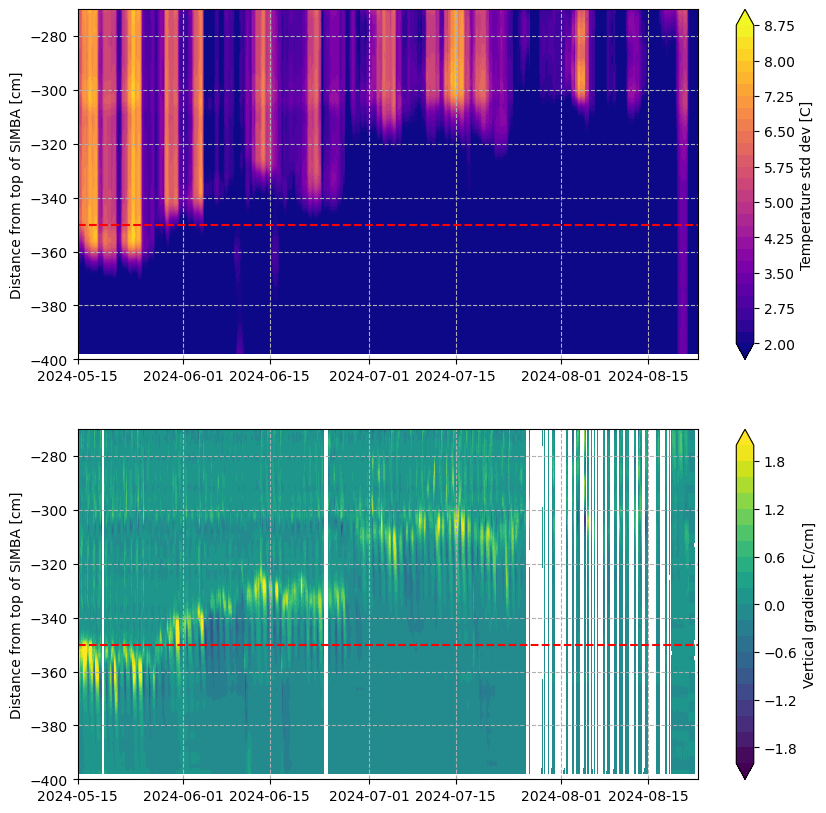

In [8]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)
cb = axs[0].contourf(plt_dates, heights[vertical_subset], np.swapaxes(np.asarray(std_profiles)[:,vertical_subset],0,1),
                cmap=plt.cm.plasma, levels=np.arange(2,9,.25), extend='both')
plt.colorbar(cb, label='Temperature std dev [C]', ax=axs[0])


vert_profiles = np.ma.masked_outside(vert_profiles, -10,10)
cb = axs[1].contourf(plt_dates, heights[vertical_subset], np.swapaxes(vert_profiles,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-2,2,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[1])

axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')

plt.show()

Plot the variables and their vertical gradients

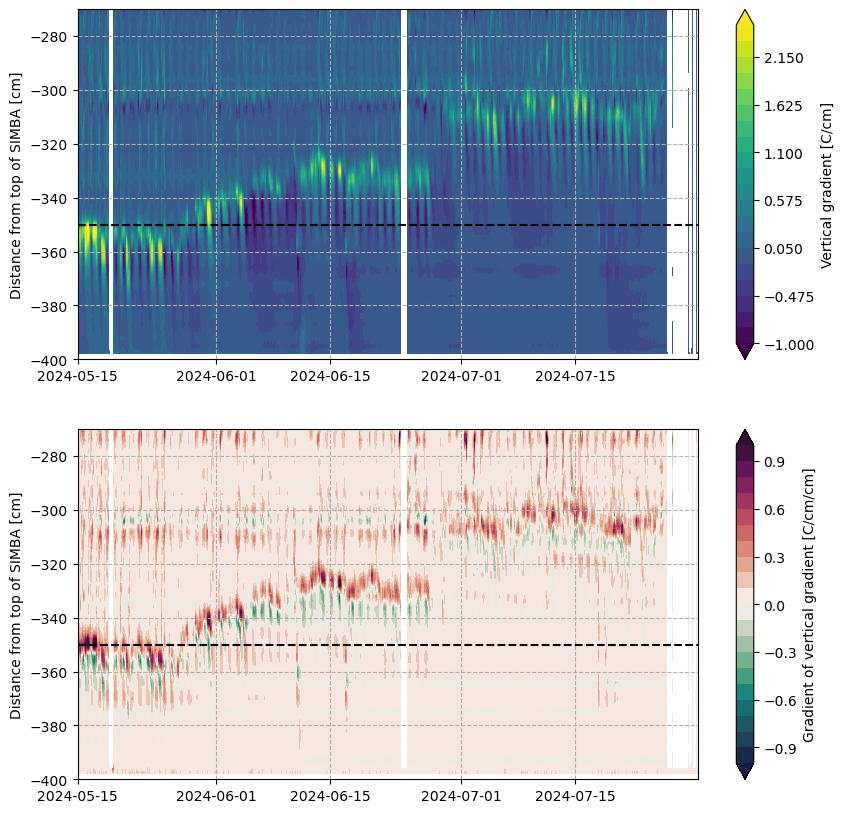

In [9]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)

vert_profiles = np.ma.masked_outside(vert_profiles, -10,10)
cb = axs[0].contourf(plt_dates, heights[vertical_subset], np.swapaxes(vert_profiles,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-1,2.5,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_profiles,-200,200)
cb = axs[1].contourf(plt_dates, heights[vertical_subset], np.swapaxes(second_vert_profiles,0,1),
                cmap=cmocean.cm.curl, levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    
# plt.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_contours_temp-vert-grad_vert-grad.png', dpi=250)

plt.show()

### Plot profiles for days during install with known surface

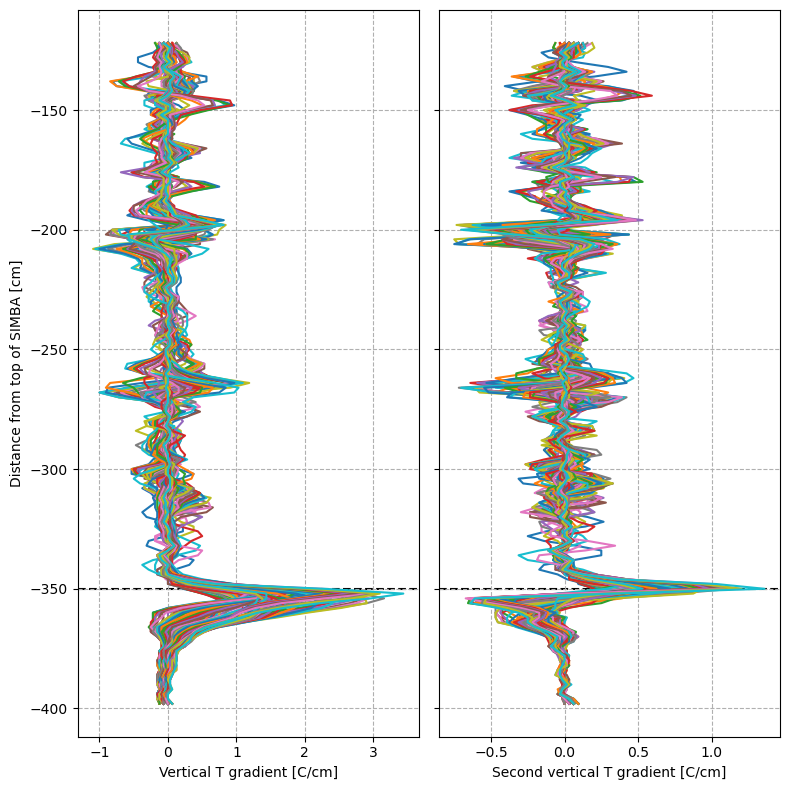

In [10]:
fig, axs = plt.subplots(1,2, figsize=(8,8), sharey=True)



for t in range(120):
    axs[0].plot(vert_profiles[t,:], heights[vertical_subset])
    axs[1].plot(second_vert_profiles[t,:], heights[vertical_subset])

axs[0].set_ylabel('Distance from top of SIMBA [cm]')
axs[0].set_xlabel('Vertical T gradient [C/cm]')
axs[1].set_xlabel('Second vertical T gradient [C/cm]')

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--', zorder=0) ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    
plt.tight_layout()
# plt.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_profiles_vert-grads.png', dpi=250)

plt.show()

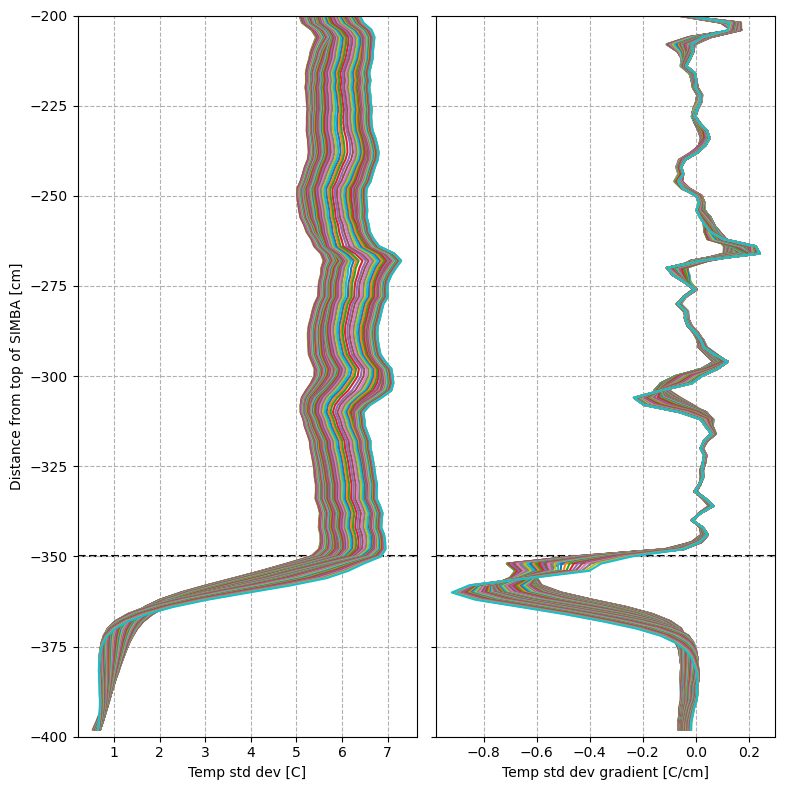

In [11]:
fig, axs = plt.subplots(1,2, figsize=(8,8), sharey=True)

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--', zorder=0) ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylim(-400,-200)

for t in range(120):
    axs[0].plot(np.asarray(std_profiles)[t,vertical_subset], heights[vertical_subset])
    axs[1].plot(np.asarray(std_gradient_profiles)[t,vertical_subset], heights[vertical_subset])

axs[0].set_ylabel('Distance from top of SIMBA [cm]')
axs[0].set_xlabel('Temp std dev [C]')
axs[1].set_xlabel('Temp std dev gradient [C/cm]')


    
plt.tight_layout()
plt.show()

What does surface ID look like if I just use the max of the second derivative?

NEW thing to try: smoothing the profile, either of the gradient or the temperature before calculating the gradient: no significant difference :/

# HERE adjust the acceptable bounds for the time steps where the "identified surface" is much lower than what looks realistic
Probably unrealistic to have have such a sudden drop, right?

In [12]:
## give some rough estimates/bounds of where you expect the surface to be
## cuts down on noise
array_dates = np.asarray(plt_dates)
upper_guess = np.full(vert_profiles.shape[0], -340)
upper_guess[np.where((array_dates>datetime.datetime(2024,5,25))&(array_dates<=datetime.datetime(2024,6,27)))[0]] = -315
upper_guess[np.where((array_dates>datetime.datetime(2024,6,27))&(array_dates<=datetime.datetime(2024,7,30)))[0]] = -290

lower_guess = np.full(vert_profiles.shape[0], -370)
lower_guess[np.where((array_dates>datetime.datetime(2024,5,25))&(array_dates<=datetime.datetime(2024,6,27)))[0]] = -360
lower_guess[np.where((array_dates>datetime.datetime(2024,6,27))&(array_dates<=datetime.datetime(2024,7,30)))[0]] = -320

## specific for isothermal times
lower_guess[np.where((array_dates>datetime.datetime(2024,6,4))&(array_dates<=datetime.datetime(2024,6,12)))[0]] = -340
lower_guess[np.where((array_dates>datetime.datetime(2024,6,4))&(array_dates<=datetime.datetime(2024,6,12)))[0]] = -340

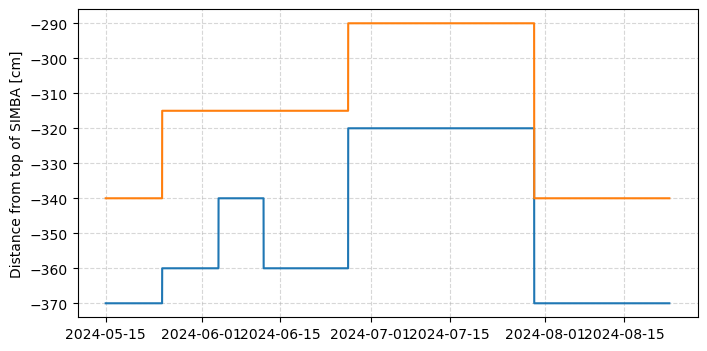

In [13]:
fig, ax= plt.subplots(1, figsize=(8,4))

plt.plot(array_dates, lower_guess)
plt.plot(array_dates, upper_guess)
plt.ylabel('Distance from top of SIMBA [cm]')
plt.grid(alpha=.5, ls='--')
# fig.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_sfc-id_method-bounds.png', dpi=250)

In [14]:
heights_subset = heights[vertical_subset]

In [15]:
# second_vert_profiles_sm = np.asarray(second_vert_profiles_sm)

In [16]:
sfc_id = []
sfc_id_idx = []

for i in range(second_vert_profiles.shape[0]):

    masked_vert = np.ma.masked_where(heights_subset>upper_guess[i], second_vert_profiles[i,:])
    masked_vert = np.ma.masked_where(heights_subset<lower_guess[i], masked_vert)

    masked_vert = np.ma.masked_where(np.asarray(std_gradient_profiles)[i,vertical_subset]<-0.3, masked_vert)

    sfc_idx = np.ma.where(masked_vert==np.ma.max(masked_vert))

    if (array_dates[i]>datetime.datetime(2024,6,5)) and (array_dates[i]<datetime.datetime(2024,6,12)):
        print(array_dates[i], heights_subset[sfc_idx])

    if len(sfc_idx[0])==0:
        sfc_id_idx.append(0)
        sfc_id.append(0)
        continue
    elif len(sfc_idx[0])>1:
        sfc_idx = sfc_idx[0][-1]
    else:
        sfc_idx = sfc_idx[0][0]
        
    sfc_id_idx.append(sfc_idx)
    sfc_id.append(heights_subset[sfc_idx])


    # print(type(heights_subset[sfc_idx]))

2024-06-05 00:15:00 [-318 -326 -328]
2024-06-05 00:30:00 [-328]
2024-06-05 00:45:00 [-326]
2024-06-05 01:00:00 [-318]
2024-06-05 01:15:00 [-318]
2024-06-05 01:30:00 [-324 -326 -328 -330]
2024-06-05 01:45:00 [-318]
2024-06-05 02:00:00 [-326 -328]
2024-06-05 02:15:00 [-318 -324 -326 -330]
2024-06-05 02:30:00 [-318 -326]
2024-06-05 02:45:00 [-318 -328]
2024-06-05 03:00:00 [-318]
2024-06-05 03:15:00 [-328]
2024-06-05 03:30:00 [-318]
2024-06-05 03:45:00 [-328]
2024-06-05 04:00:00 [-316 -324 -326]
2024-06-05 04:15:00 [-316 -324 -328]
2024-06-05 04:30:00 [-318]
2024-06-05 04:45:00 [-318]
2024-06-05 05:00:00 [-328]
2024-06-05 05:15:00 [-328]
2024-06-05 05:30:00 [-318]
2024-06-05 05:45:00 [-318 -324 -326]
2024-06-05 06:00:00 [-318 -326]
2024-06-05 06:15:00 [-318 -326]
2024-06-05 06:30:00 [-318]
2024-06-05 06:45:00 [-318 -324 -326]
2024-06-05 07:00:00 [-318 -324 -326 -328]
2024-06-05 07:15:00 [-318 -324 -326]
2024-06-05 07:30:00 [-318 -324 -326]
2024-06-05 07:45:00 [-316 -318 -320 -322 -324 -326

In [17]:
sfc_id = np.ma.masked_less(sfc_id, -380)
sfc_id = np.ma.masked_equal(sfc_id, 0)
sfc_id = np.ma.masked_equal(sfc_id, -280)


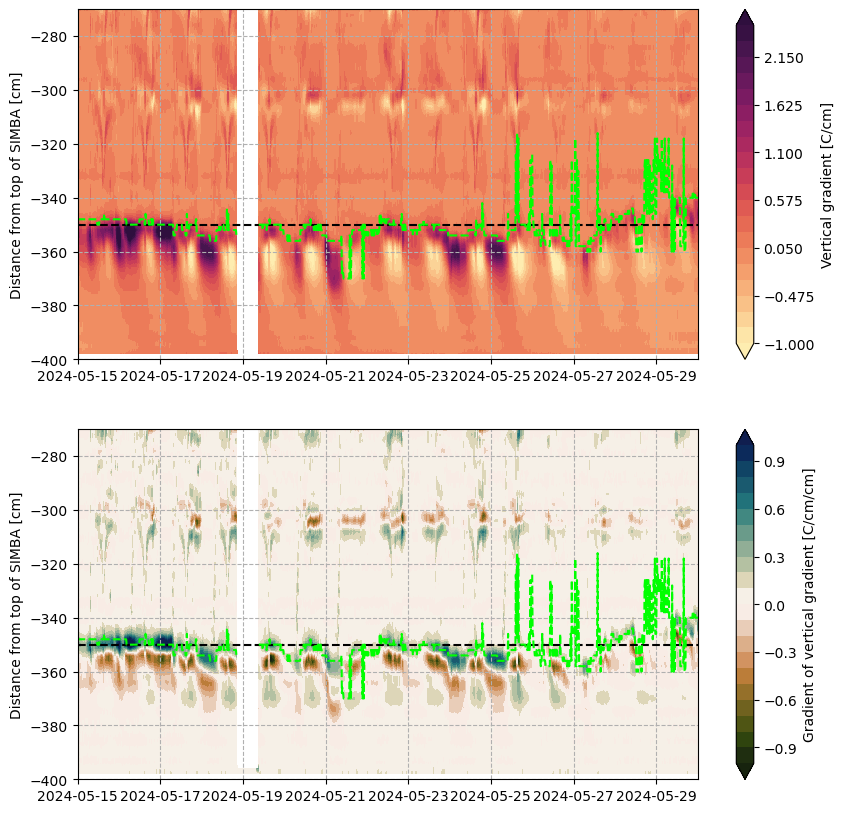

In [18]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)

vert_profiles = np.ma.masked_outside(vert_profiles, -10,10)
cb = axs[0].contourf(plt_dates, heights[vertical_subset], np.swapaxes(vert_profiles,0,1),
                cmap=cmocean.cm.matter, levels=np.linspace(-1,2.5,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_profiles,-200,200)
cb = axs[1].contourf(plt_dates, heights[vertical_subset], np.swapaxes(second_vert_profiles,0,1),
                cmap=cmocean.cm.tarn, levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.plot(plt_dates, sfc_id, c='lime', ls='--')
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,5,30))
plt.show()

vert_profiles = np.ma.masked_outside(vert_profiles, -10,10)
second_vert_profiles = np.ma.masked_outside(second_vert_profiles,-200,200)


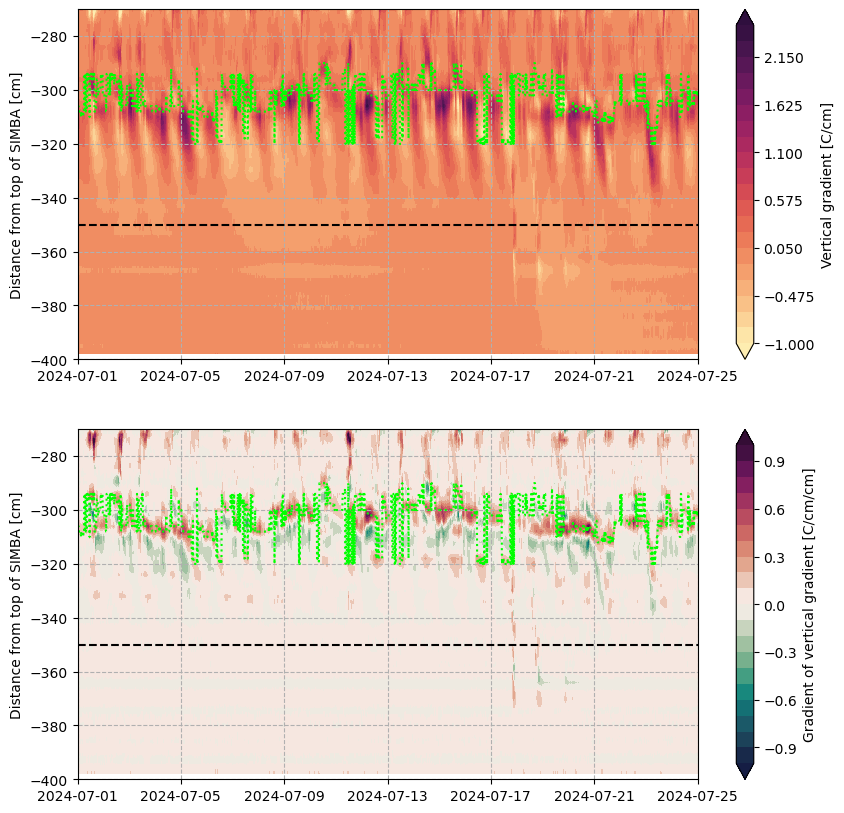

In [19]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)

cb = axs[0].contourf(plt_dates, heights[vertical_subset], np.swapaxes(vert_profiles,0,1),
                cmap=cmocean.cm.matter, levels=np.linspace(-1,2.5,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

cb = axs[1].contourf(plt_dates, heights[vertical_subset], np.swapaxes(second_vert_profiles,0,1),
                cmap=cmocean.cm.curl, levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.plot(plt_dates, sfc_id, c='lime', ls=':')
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime.datetime(2024,7,1), datetime.datetime(2024,7,25))
plt.show()

### Need to remove spikes/de-noise/???

/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


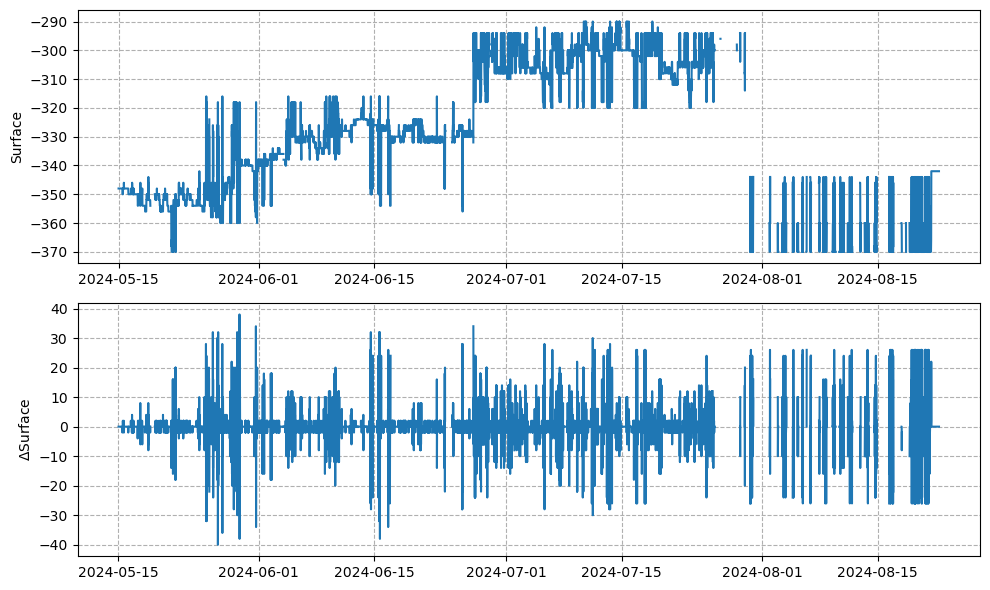

In [20]:
## test if changes in sfc can be used to remove spikes?

fig, axs = plt.subplots(2, figsize=(10,6))

axs[0].plot(plt_dates, sfc_id)

axs[1].plot(plt_dates[1:], [a-b for a,b in zip(sfc_id[1:],sfc_id[:-1])] )

for ax, label in zip(axs.ravel(),['Surface', '$\Delta$Surface']):
    ax.grid(ls='--')
    ax.set_ylabel(label)

    # ax.set_xlim(datetime.datetime(2024,7,15),datetime.datetime(2024,7,27))

plt.tight_layout()
plt.show()


In [21]:
plt_dates = np.asarray(plt_dates)

In [22]:
## test if interpolating sfc before running mean helps to get ID before the large accumulation
plt_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in plt_dates])
# set assume_sorted to have scipy automatically sort for you
f_0 = interpolate.interp1d(plt_seconds[~sfc_id.mask], sfc_id[~sfc_id.mask], assume_sorted = False, fill_value='extrapolate')
filled_sfc_id = f_0(plt_seconds)

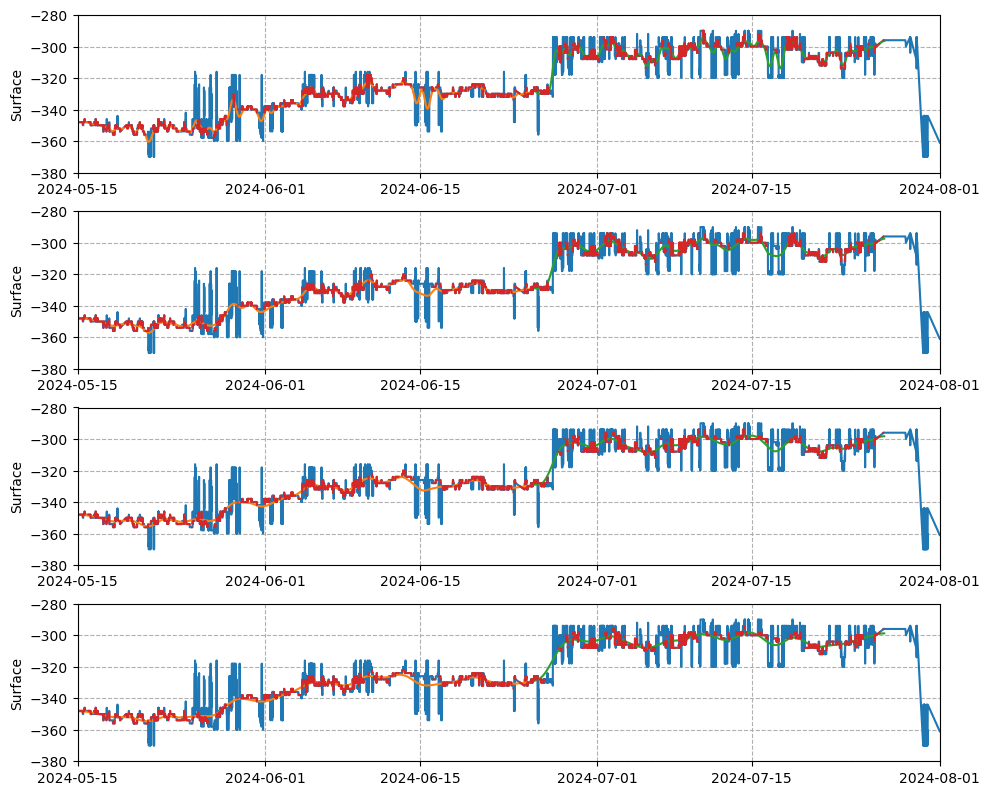

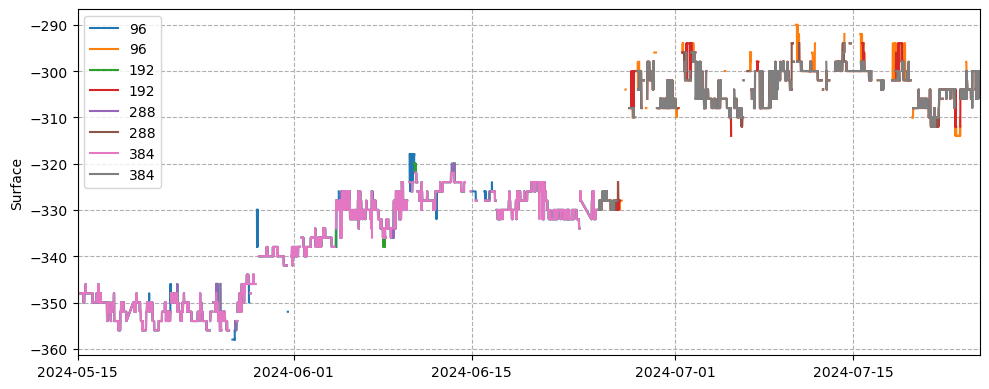

In [23]:
## use noise relative to running mean to remove spikes
## split up into two segments 


seg_1_idx = np.where((plt_dates>datetime.datetime(2024,5,15))&(plt_dates<datetime.datetime(2024,6,25)))[0]
seg_2_idx = np.where((plt_dates>=datetime.datetime(2024,6,25))&(plt_dates<datetime.datetime(2024,7,27)))[0]

fig, axs = plt.subplots(4, figsize=(10,8))

fig_sfc, ax_sfc = plt.subplots(1, figsize=(10,4))

for wlen, ax in zip([4*24, 2*4*24, 3*4*24, 4*4*24], axs.ravel()):
    ax.plot(plt_dates, filled_sfc_id)


    for seg_idx in [seg_1_idx,seg_2_idx]:
        smoothed = smooth(filled_sfc_id[seg_idx], window_len=wlen+1, window='hanning')
        ax.plot(plt_dates[seg_idx], smoothed[int(wlen/2):-int(wlen/2)])
        
        diffed = smoothed[int(wlen/2):-int(wlen/2)]-filled_sfc_id[seg_idx]
        # axs[1].plot(plt_dates[:], diffed )
        
        ax.plot(plt_dates[seg_idx], np.ma.masked_where(np.ma.abs(diffed)>5, filled_sfc_id[seg_idx]), ls='--', c='tab:red')
    
        ax_sfc.plot(plt_dates[seg_idx], np.ma.masked_where(np.ma.abs(diffed)>5, filled_sfc_id[seg_idx]), label=wlen)
    
for ax in axs.ravel():
    ax.grid(ls='--')
    ax.set_ylabel('Surface')

    ## looking more closely at times with unrealistic dips due to isothermal conditions
    ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,8,1))
    ax.set_ylim(-380,-280)
    
ax_sfc.grid(ls='--')
ax_sfc.set_ylabel('Surface')
ax_sfc.legend(loc='best')
ax_sfc.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,25))
fig_sfc.tight_layout()
fig.tight_layout()

# fig.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_sfc-id-timeseries_smoothing-windows.png', dpi=250)
# fig_sfc.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_sfc-id-timeseries_smoothing-windows-comparison.png', dpi=250)

plt.show()


In [24]:
## Orignial without splitting into two segments...

## keep red line (largest window), interpolate between steps
wlen = 4*4*24 # 4 days
smoothed = smooth(sfc_id,window_len=wlen+1,window='hanning')
diffed = smoothed[int(wlen/2):-int(wlen/2)]-sfc_id
masked_sfc = np.ma.masked_where(np.ma.abs(diffed)>5, sfc_id)


# interpolate here, need sceonds
plt_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in plt_dates])
# set assume_sorted to have scipy automatically sort for you
f = interpolate.interp1d(plt_seconds[~masked_sfc.mask], masked_sfc[~masked_sfc.mask], assume_sorted = False, fill_value='extrapolate')
filled_sfc = f(plt_seconds)

In [25]:
## keep red line (largest window), interpolate between steps
# seg_1_idx = np.where((plt_dates>datetime.datetime(2024,5,15))&(plt_dates<datetime.datetime(2024,6,25)))[0]
# seg_2_idx = np.where((plt_dates>=datetime.datetime(2024,6,25))&(plt_dates<datetime.datetime(2024,7,27)))[0]

seg_1_idx = np.where(plt_dates<datetime.datetime(2024,6,25))[0]
seg_2_idx = np.where(plt_dates>=datetime.datetime(2024,6,25))[0]

wlen = 4*4*24 # 4 days

for n, seg_idx in enumerate([seg_1_idx,seg_2_idx]):
    smoothed = smooth(filled_sfc_id[seg_idx], window_len=wlen+1, window='hanning')
    diffed = smoothed[int(wlen/2):-int(wlen/2)]-filled_sfc_id[seg_idx]
    masked_sfc = np.ma.masked_where(np.ma.abs(diffed)>5, filled_sfc_id[seg_idx])
    # print(masked_sfc[np.ma.where(masked_sfc>-280)[0]])

    if n==0:
        total_mask_sfc = masked_sfc
    else:
        total_mask_sfc = np.ma.concatenate((total_mask_sfc, masked_sfc))
    # print(filled_sfc[:50])

# interpolate here, need sceonds
plt_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in plt_dates])
# set assume_sorted to have scipy automatically sort for you
f = interpolate.interp1d(plt_seconds[~total_mask_sfc.mask], total_mask_sfc[~total_mask_sfc.mask], assume_sorted = False, fill_value='extrapolate')
filled_sfc = f(plt_seconds)

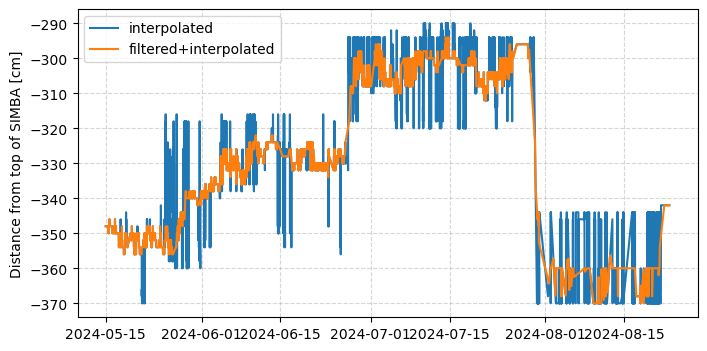

In [26]:
fig, ax= plt.subplots(1, figsize=(8,4))
plt.plot(plt_dates, filled_sfc_id, label='interpolated')
plt.plot(plt_dates, filled_sfc, c='tab:orange', label='filtered+interpolated')
# plt.xlim(datetime.datetime(2024,6,22), datetime.datetime(2024,7,1))
# plt.ylim(-360,-280)
plt.ylabel('Distance from top of SIMBA [cm]')
plt.grid(alpha=.5,ls='--')
plt.legend(loc='best')
# fig.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_sfc-id-timeseries_interp-filter.png', dpi=250)

plt.show()

sfc_changes = [a-b for a,b in zip(sfc_id[1:],sfc_id[:-1])]
sfc_changes.insert(0, 0)
sfc_changes = np.ma.masked_outside(sfc_changes, -10,10)
masked_sfc = np.ma.masked_array(sfc_id, mask=sfc_changes.mask)


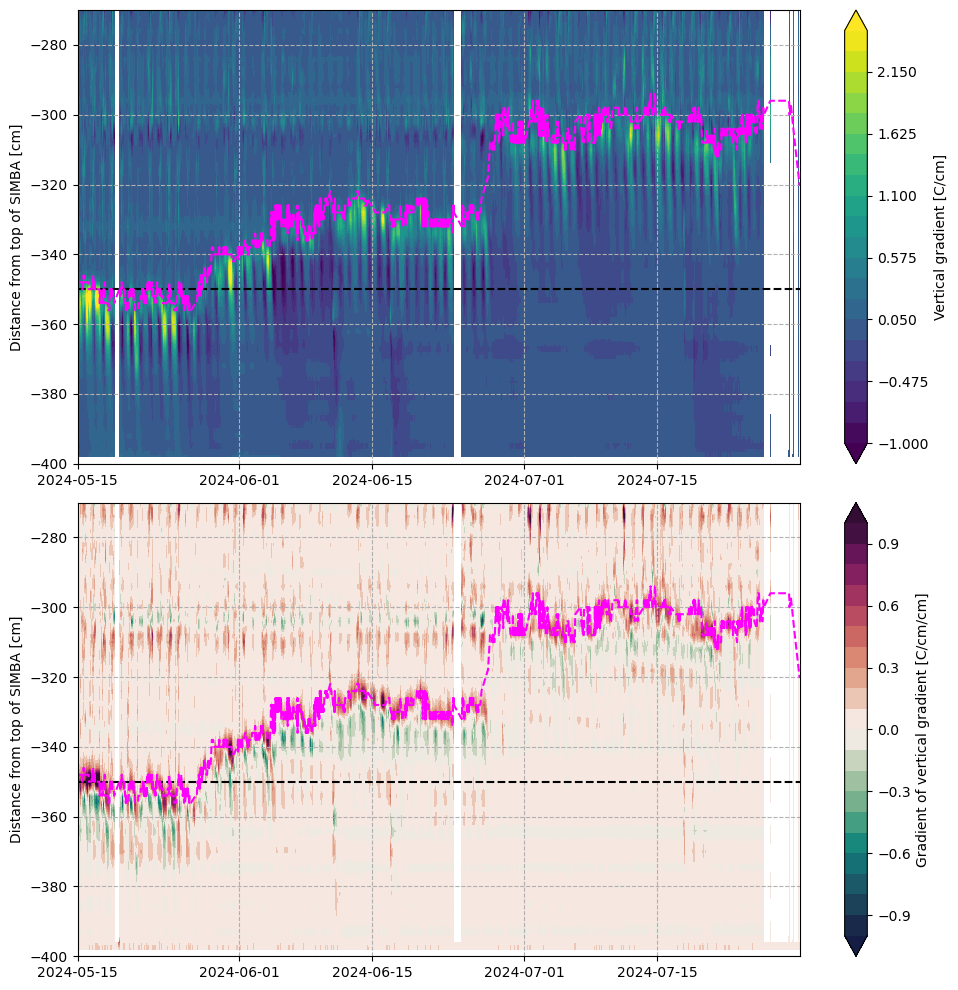

In [27]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)

cb = axs[0].contourf(plt_dates, heights[vertical_subset], np.swapaxes(vert_profiles,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-1,2.5,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

cb = axs[1].contourf(plt_dates, heights[vertical_subset], np.swapaxes(second_vert_profiles,0,1),
                cmap=cmocean.cm.curl, levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    # ax.plot(plt_dates, masked_sfc, c='magenta', lw=1, ls='--')
    ax.plot(plt_dates, filled_sfc, c='magenta', ls='--')
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
plt.tight_layout()
# fig.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_T-vert-grads_sfc-id-timeseries.png', dpi=250)

plt.show()

In [28]:
print(np.shape(plt_dates), season_data['dates'].shape)
print(plt_dates[-1], season_data['dates'][-1])

(9312,) (9504,)
2024-08-22 23:45:00 2024-08-22 23:45:00


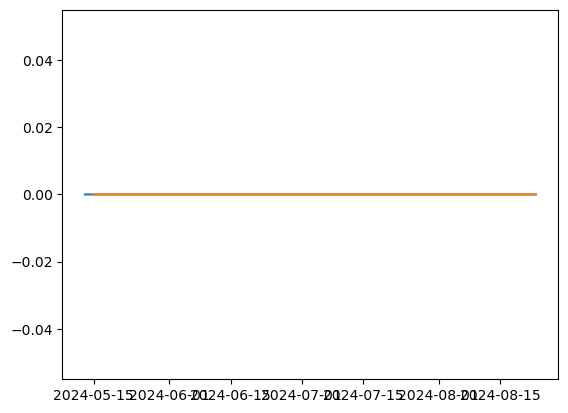

In [29]:
## add padding to sfc heights so that it's the same shape as the data from the SIMBA files!!!

plt.plot(season_data['dates'], [0 for _ in range(len(season_data['dates']))])
plt.plot(plt_dates, [0 for _ in range(len(plt_dates))])
plt.show()

In [32]:
pad = season_data['dates'].shape[0] - filled_sfc.shape[0]
padded_filled_sfc = np.ma.concatenate((np.zeros(pad), filled_sfc))
print(padded_filled_sfc.shape)

## make consistent masking
padded_filled_sfc = np.ma.masked_equal(padded_filled_sfc,0)
padded_filled_sfc[padded_filled_sfc.mask] = -999
padded_filled_sfc = np.ma.masked_equal(padded_filled_sfc, -999)

(9504,)


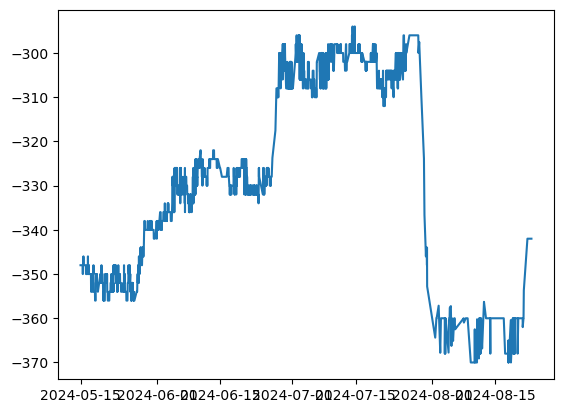

In [33]:
plt.plot(season_data['dates'], padded_filled_sfc)
plt.show()

In [34]:
## save for future use
# np.savez_compressed('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad_20250123.npz', data=padded_filled_sfc.data, mask=padded_filled_sfc.mask)


In [105]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

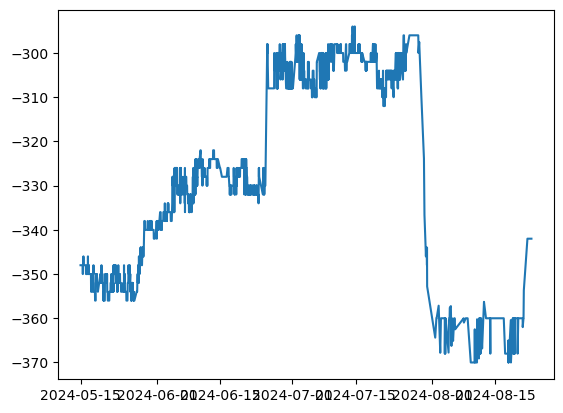

In [106]:
plt.plot(season_data['dates'], arr)
plt.show()